## Description
This notebook compares the actual data and the posterior distribution generated by the model. When we actually
run the optimizer and do Thompson sampling, we make not one but many posterior distributions based on the data.
In this notebook, we take the most probable posterior distribution and plot it against the actual data. 

In a way, this is a method of sanity check. If the posterior distribution is way off, we know that it's wrong. 
We can also check that the average CPMs the two models outputs are roughly similar.

In [2]:
## Set auto-reload
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import gamma as gamma_func
from scipy.stats import gamma
from scipy.stats import norm

from prebid_optimizer.reader import TSReader
from prebid_optimizer.models import BetaLogNormalModel
from prebid_optimizer.models import GammaModel

%matplotlib inline

## Data

In [4]:
DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"
TIMEOUTS = [800, 1000, 1500, 2000, 2500]

In [5]:
reader = TSReader(
    config_id="d385ba19-47da-48e9-ab1b-cdfb4149118b",    
    source_table="ox-datascience-devint.prebid.auctions_raw_lainey_gossip",
    configs_to_optimize={"bidderTimeout":TIMEOUTS},
    gcp_project="ox-datascience-devint"
)

In [6]:
start_timestamp = datetime.strptime("2021-10-28 12:00:00", DATETIME_FORMAT)
end_timestamp = datetime.strptime("2021-10-28 18:00:00", DATETIME_FORMAT)
all_data = reader.get_data(start_timestamp, end_timestamp, True)

2021-10-28 12:00:00 2021-10-28 18:00:00 6


In [7]:
display(all_data.head())
display(all_data.shape)
display(all_data.describe())

,auction_hour,bidderTimeout,win,pubrev
0,5,1000,0,0
1,5,1000,0,0
2,5,1000,0,0
3,5,1000,0,0
4,5,1000,0,0


(175244, 4)

,auction_hour,bidderTimeout,win,pubrev
count,175244.000000,175244.000000,175244.000000,1.752440e+05
mean,3.203522,1759.600899,0.134350,3.490014e+05
std,1.428101,626.450379,0.341029,1.660723e+06
min,0.000000,600.000000,0.000000,0.000000e+00
25%,2.000000,1000.000000,0.000000,0.000000e+00
50%,3.000000,1500.000000,0.000000,0.000000e+00
75%,4.000000,2500.000000,0.000000,0.000000e+00
max,5.000000,3000.000000,1.000000,8.099999e+07


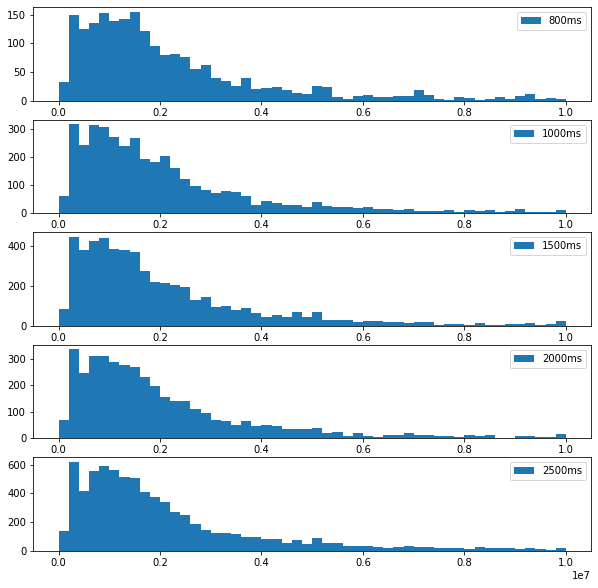

In [8]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
for idx, timeout in enumerate(TIMEOUTS):
    sub_df = all_data[all_data["bidderTimeout"] == timeout]
    ax[idx].hist(sub_df["pubrev"], bins=np.linspace(1,1e7, 51), label=f"{timeout}ms")
    ax[idx].legend()

## Gamma model

In [9]:
""" 
1. Fit the gamma_model to data
2. Generate 100k posterior params (beta)
3. Use the mean beta to get a single gamma distribution
4. Plot gamma distribution and compare against data
"""
def compare_distributions_g(all_data, timeouts, xlim):
    
    fig, ax = plt.subplots(5, 2, figsize=(10, 10))
    gamma_model = GammaModel(alpha0=0.08)
    
    for idx, timeout in enumerate(timeouts):
        # Select subset of the data
        df = all_data[all_data["bidderTimeout"] == timeout]
        
        # Get hyperparams
        hyperparams = gamma_model.get_posterior_hyperparams(df)

        # Get pdf
        pdf_func, beta_min, beta_max = gamma_model.get_pdf_func(hyperparams)

        # Test pdf
        gamma_model.test_pdf(pdf_func, beta_min, beta_max)

        # Get cdf
        betas, cdf = gamma_model.get_cdf_array(beta_min, beta_max, pdf_func)

        # Get alpha and beta
        random_betas = gamma_model.get_random_betas(betas, cdf, N=100000)
        alpha = hyperparams["alpha"] 
        beta = random_betas.mean()

        # Plot distributions
        plt.figure()

        n = len(df)
        num_bins = 50

        gamma_dist = lambda x: gamma.pdf(x, a=alpha, scale=1/beta)
        prices = np.linspace(0.9e-6, xlim, num_bins)
        probs = np.array([integrate.quad(gamma_dist, prices[i], prices[i+1])[0] for i in range(num_bins-1)]) * n
        mid_points = (prices[:-1] + prices[1:]) / 2

        stat_summary_str = f"mean cpm={alpha / beta:.4f}"
        ax[idx,0].plot(mid_points, probs, label=stat_summary_str)
        ax[idx,0].hist((df["pubrev"] + 1 ) / 1e6, bins=prices, log=True)
        ax[idx,0].set_ylim(0.5, 1e5)
        ax[idx,0].legend()
        
        ax[idx,1].hist((df["pubrev"] + 1) / 1e6, bins = np.linspace(0, xlim * 2, 50), log=True, label=f"{timeout}ms")
        ax[idx,1].legend()
        


    ax[0,0].set_title("zoomed-in", fontsize=13)
    ax[0,1].set_title("zoomed-out", fontsize=13)    
    ax[-1,0].set_xlabel("CPM (usd)", fontsize=13)    
    ax[-1,1].set_xlabel("CPM (usd)", fontsize=13) 
    
    fig.suptitle("Gamma model fit", fontsize=15)
    fig.tight_layout()
    
    if not os.path.exists("output/"):
        os.mkdir("output")
    fig.savefig(f"output/model_fit_gamma.png", dpi=150)

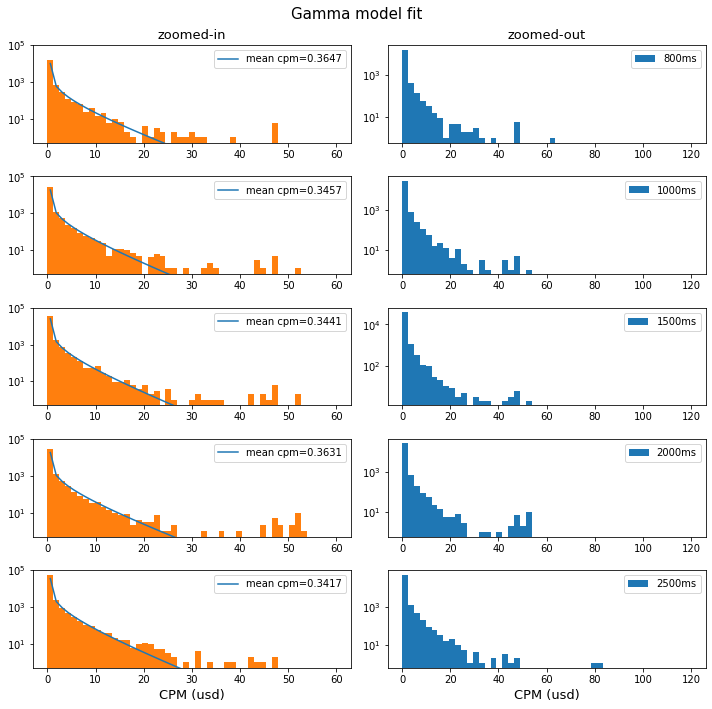

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
compare_distributions_g(all_data, TIMEOUTS, xlim=60)

## BetaLogNormal model

In [11]:
""" 
1. Fit the beta lognormal model to data
2. Generate 100k posterior hyperparams
3. Use the mean values to get a single lognormal distribution
4. Plot lognormal distribution and compare against data
"""
def compare_distributions_bl(all_data, timeouts, logx_lo, logx_hi):
    
    fig, ax = plt.subplots(5, 2, figsize=(10, 10))
    bn_model = BetaLogNormalModel()    

    for idx, timeout in enumerate(timeouts):
        # Select subset of the data
        df = all_data[all_data["bidderTimeout"] == timeout]
        
        # Get hyperparams
        hyperparams = bn_model.get_posterior_hyperparams(df)

        # Get alpha and beta
        _, (X, T) = bn_model._get_lognormal_means(hyperparams, N=100000)

        mu = X.mean()
        tau = T.mean()
        v = hyperparams["v"]

        wins = df[df["pubrev"] > 0]
        n = len(wins)

        sigma = np.sqrt(1 / (v * tau)) * np.sqrt(n)

        lognormal_mu = np.exp(mu + 1 / (2 * 1 * tau) )
        win_rate = len(wins) / len(df)

        # Plot distributions
        n = len(wins)

        num_bins = 50

        normal_dist = lambda x: norm.pdf(x, loc=mu, scale=sigma)
        prices = np.linspace(logx_lo, logx_hi, num_bins)
        probs = np.array([integrate.quad(normal_dist, prices[i], prices[i+1])[0] for i in range(len(prices)-1)]) * n
        mid_points = (prices[:-1] + prices[1:]) / 2

        auc = integrate.quad(normal_dist, logx_lo, logx_hi)[0]
        if auc < 0.99:
            print(f"integrated to {auc}")


        ax[idx,0].plot(mid_points, probs, label=f"{timeout}ms")
        ax[idx,0].hist(np.log(wins["pubrev"] + 1), bins=prices)
        ax[idx,0].legend()

        stat_summary_str = f"mean cpm={lognormal_mu * win_rate / 1e6:.3f}, mean win cpm={lognormal_mu / 1e6:.3f}"
        ax[idx,1].plot(np.exp(mid_points) / 1e6, probs, label=stat_summary_str)
        ax[idx,1].hist(wins["pubrev"] / 1e6, bins=np.exp(mid_points) / 1e6)

        ax[idx,1].set_xlim(0, np.exp(logx_hi) / 1e6 / 3)
        ax[idx,1].legend()

    ax[0, 0].set_title("log x-scale", fontsize=14)        
    ax[0,1].set_title("linear x-scale", fontsize=14)

    ax[-1,0].set_xlabel("log microusd CPM", fontsize=13)
    ax[-1,1].set_xlabel("CPM (usd)", fontsize=13)
    
    fig.suptitle(f"Beta lognormal fit", fontsize=15)
    fig.tight_layout()
    
    if not os.path.exists("output/"):
        os.mkdir("output")
    fig.savefig(f"output/model_fit_beta_lognormal.png", dpi=150)

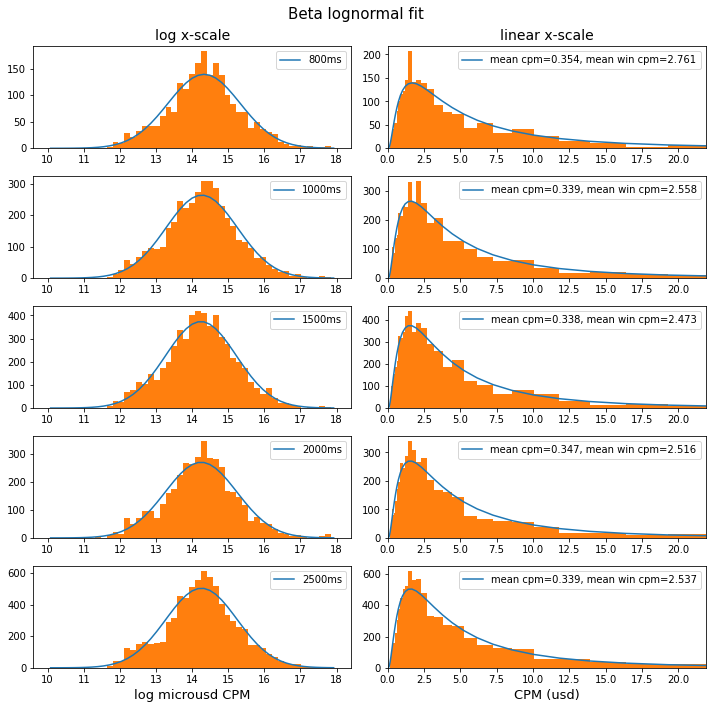

In [12]:
compare_distributions_bl(all_data, TIMEOUTS, logx_lo=10, logx_hi=18)